# Kaggle Compeition Notebook

- Author: Dr. Muhammad Aammar Tufail
- LinkedIn: https://www.linkedin.com/in/draammartufail/
- Github: 
- Twitter: https://twitter.com/aammar_tufail
- youtube: https://www.youtube.com/channel/UCjPk9YDheKst1FlAf_KSpyA
- Website: https://www.codanics.com/

# **Survival Rate predicted by Neural Network in Tensorflow**

In [110]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [111]:
# load the data
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/gender_submission.csv')

In [112]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [113]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [114]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# Let's explore the data df_train.csv

In [115]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [116]:
(df_train.isnull().sum() / len(df_train) * 100 ).sort_values(ascending=False)

Cabin          77.104377
Age            19.865320
Embarked        0.224467
PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
dtype: float64

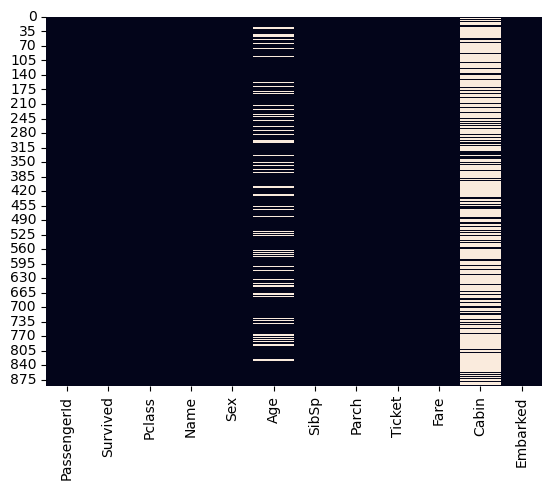

In [117]:
# plot the null values
sns.heatmap(df_train.isnull(), cbar=False)
plt.show()

In [118]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [119]:
df = df_train.copy()

# Function to impute missing values from df

In [120]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, r2_score, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['Cabin', 'Embarked']
bool_cols = []
numeric_cols = ['Age']

missing_data_cols = df.isnull().sum()[df.isnull().sum() > 0].index.tolist()

# define the function to impute the missing values in thal column

def impute_categorical_missing_data(passed_col):
    
    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    if passed_col in bool_cols:
        y = label_encoder.fit_transform(y)
        
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_classifier = RandomForestClassifier()

    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)

    print("The feature '"+ passed_col+ "' has been imputed with", round((acc_score * 100), 2), "accuracy\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_classifier.predict(X)
        if passed_col in bool_cols:
            df_null[passed_col] = df_null[passed_col].map({0: False, 1: True})
        else:
            pass
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

def impute_continuous_missing_data(passed_col):
    
    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])
    
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_regressor = RandomForestRegressor()

    rf_regressor.fit(X_train, y_train)

    y_pred = rf_regressor.predict(X_test)

    print("MAE =", mean_absolute_error(y_test, y_pred), "\n")
    print("RMSE =", mean_squared_error(y_test, y_pred, squared=False), "\n")
    print("R2 =", r2_score(y_test, y_pred), "\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_regressor.predict(X)
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

# remove warning
import warnings
warnings.filterwarnings('ignore')

# impute missing values using our functions
for col in missing_data_cols:
    print("Missing Values", col, ":", str(round((df[col].isnull().sum() / len(df)) * 100, 2))+"%")
    if col in categorical_cols:
        df[col] = impute_categorical_missing_data(col)
    elif col in numeric_cols:
        df[col] = impute_continuous_missing_data(col)
    else:
        pass

(df.isnull().sum() / len(df) * 100 ).sort_values(ascending=False)

Missing Values Age : 19.87%


MAE = 9.358898601398602 

RMSE = 11.836750632199747 

R2 = 0.24430695203172348 

Missing Values Cabin : 77.1%
The feature 'Cabin' has been imputed with 24.39 accuracy

Missing Values Embarked : 0.22%
The feature 'Embarked' has been imputed with 89.33 accuracy



PassengerId    0.0
Survived       0.0
Pclass         0.0
Name           0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Ticket         0.0
Fare           0.0
Cabin          0.0
Embarked       0.0
dtype: float64

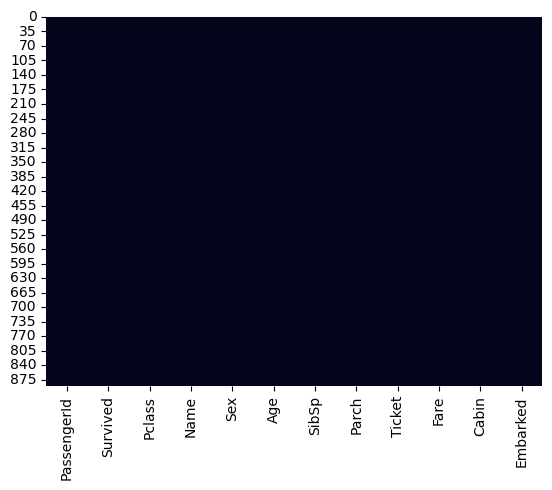

In [121]:
# plot missing values
sns.heatmap(df.isnull(), cbar=False)
plt.show()

Missing values have been imputed or removed from the data set. 

In [122]:
# split the data into X and y
X = df.drop(['Survived', 'Name'], axis=1)
y = df['Survived']

# encode the data
label_encoder = LabelEncoder()

for col in X.columns:
    if X[col].dtype == 'object' or X[col].dtype == 'category':
        X[col] = label_encoder.fit_transform(X[col])
    else:
        pass
    
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [123]:
X_train.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
331,332,1,1,45.5,0,0,20,28.5000,56,2
733,734,2,1,23.0,0,0,228,13.0000,90,2
382,383,3,1,32.0,0,0,665,7.9250,115,2
704,705,3,1,26.0,1,0,398,7.8542,143,2
813,814,3,0,6.0,4,2,333,31.2750,20,2


# Create a Neural Network for Binary Classification

In [124]:
# use tensorflow to create a neural network
import tensorflow as tf

# Building the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', 
                          input_shape=(X_train.shape[1],)), # Input layer
    tf.keras.layers.Dense(64, activation='relu'), # Hidden layer 1
    tf.keras.layers.Dense(32, activation='relu'), # Hidden layer 2
    tf.keras.layers.Dense(16, activation='relu'), # Hidden layer 3
    tf.keras.layers.Dense(8, activation='relu'), # Hidden layer 3
    
    tf.keras.layers.Dense(1, activation='sigmoid') # Output layer
])

In [125]:
# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Training the model
# model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# # Evaluating the model on the test set
# model.evaluate(X_test, y_test)

Epoch 1/100


2024-01-19 18:36:49.197520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 2s 32ms/step - loss: 4.6434 - accuracy: 0.6025 - val_loss: 3.1923 - val_accuracy: 0.5922
Epoch 2/100


2024-01-19 18:36:50.548916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 0s 15ms/step - loss: 2.0533 - accuracy: 0.5801 - val_loss: 2.2137 - val_accuracy: 0.6313
Epoch 3/100
23/23 [==============================] - 0s 15ms/step - loss: 1.4731 - accuracy: 0.6292 - val_loss: 0.7381 - val_accuracy: 0.6034
Epoch 4/100
23/23 [==============================] - 0s 14ms/step - loss: 4.3032 - accuracy: 0.4888 - val_loss: 6.3874 - val_accuracy: 0.4525
Epoch 5/100
23/23 [==============================] - 0s 14ms/step - loss: 8.5532 - accuracy: 0.6096 - val_loss: 9.7471 - val_accuracy: 0.3966
Epoch 6/100
23/23 [==============================] - 0s 15ms/step - loss: 5.1993 - accuracy: 0.4972 - val_loss: 2.0359 - val_accuracy: 0.5922
Epoch 7/100
23/23 [==============================] - 0s 14ms/step - loss: 3.2695 - accuracy: 0.5098 - val_loss: 1.2371 - val_accuracy: 0.6369
Epoch 8/100
23/23 [==============================] - 0s 14ms/step - loss: 2.4300 - accuracy: 0.6025 - val_loss: 5.4362 - val_accuracy: 0.5866
Epoch 9/100
23/23 

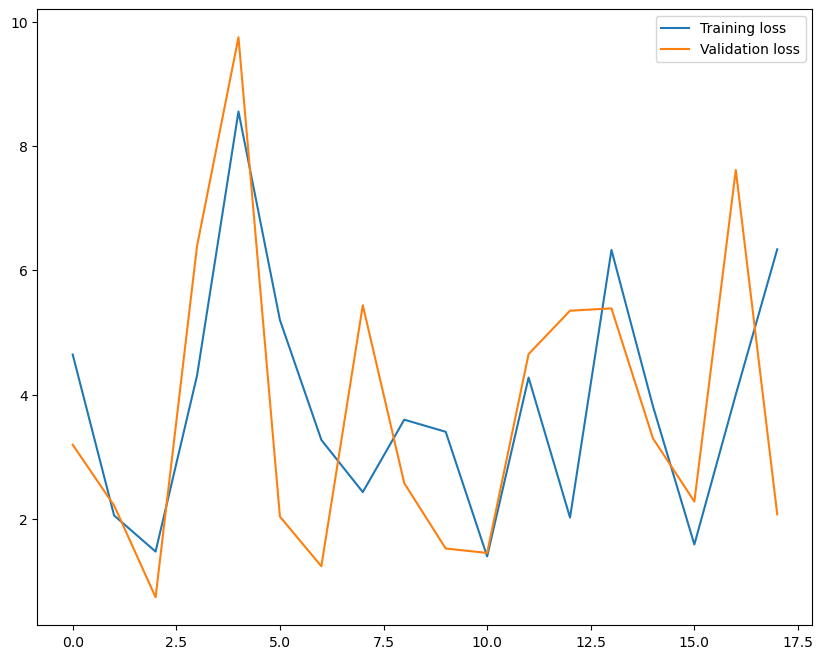

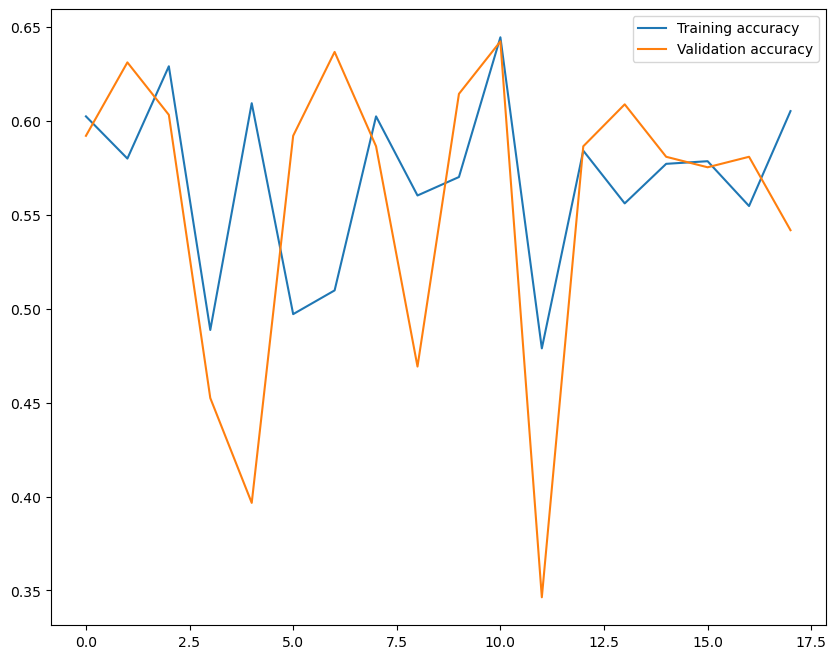

In [126]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the callback function
early_stopping = EarlyStopping(patience=15)


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# train the model and plot the training and testing loss and accuracy at each epoc
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test, y_test), 
                    callbacks=[early_stopping])

# plot the training and testing loss and accuracy at each epoc
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(history.history['loss'], label='Training loss')
ax.plot(history.history['val_loss'], label='Validation loss')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(history.history['accuracy'], label='Training accuracy')
ax.plot(history.history['val_accuracy'], label='Validation accuracy')
ax.legend()
plt.show()